### remember to change model saving path!!!

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Ge_Benq_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size, training = True, allow_zero_mask = False):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
        self.training = training
        self.allow_zero_mask = allow_zero_mask
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        dataset = self.df["dataset"][idx]
        if dataset=="ge":
            from_dataset = 1
        else:
            from_dataset = 2
        if dataset == "benq":
            from_folder = "../gland_data"
        else:
            if self.training:
                from_folder = "../ge_data/train"
            else:
                from_folder = "../ge_data/test"
        
        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0 and self.allow_zero_mask == False:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor, from_dataset

In [5]:
image_size = 128
batch_size = 1
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
test_dataset = Ge_Benq_Dataset("../ge_benq_data/ge_benq_test.csv", transform = test_augmentation, image_size = image_size, training = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

image, mask, from_dataset = next(iter(test_dataloader))

In [6]:
from_dataset==1

tensor([True])

In [7]:
from_dataset[0]

tensor(1)

In [8]:
len(test_dataset)

191

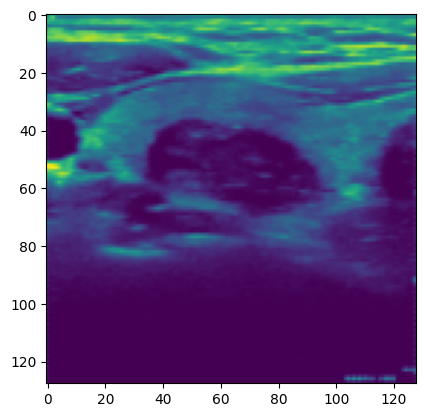

In [9]:
plt.imshow(image[0][0])

In [10]:
import torch
import numpy as np
import cv2

import torch
import numpy as np
import cv2

def postprocess_logits_mask(logits_mask, threshold=0.5):
    """
    logits_mask: torch.Tensor of shape [B, 1, H, W], raw logits
    threshold: value for converting logits to binary mask after sigmoid
    returns: torch.Tensor of shape [B, 1, H, W] with only the largest component retained
    """
    # Step 1: Convert logits to probabilities
    prob_mask = torch.sigmoid(logits_mask)

    # Step 2: Threshold to get binary mask
    binary_mask = (prob_mask > threshold).float()

    # Step 3: Remove all but the largest connected component
    binary_mask = binary_mask.squeeze(1)  # [B, H, W]
    cleaned_batch = []

    for mask in binary_mask:
        mask_np = mask.cpu().numpy().astype(np.uint8)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_np, connectivity=8)

        if num_labels <= 1:
            cleaned = np.zeros_like(mask_np)
        else:
            largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
            cleaned = (labels == largest_label).astype(np.uint8)

        cleaned_batch.append(torch.from_numpy(cleaned))

    # Stack and return to original shape [B, 1, H, W]
    cleaned_mask = torch.stack(cleaned_batch).unsqueeze(1).float().to(logits_mask.device)

    return cleaned_mask
import torch
import numpy as np
import cv2
from scipy.ndimage import binary_fill_holes

def postprocess_logits_with_fill(logits_mask, threshold=0.5):
    """
    logits_mask: torch.Tensor of shape [B, 1, H, W], raw logits
    returns: torch.Tensor of shape [B, 1, H, W], cleaned mask
    """
    # Step 1: Apply sigmoid + threshold
    prob_mask = torch.sigmoid(logits_mask)
    binary_mask = (prob_mask > threshold).float()
    binary_mask = binary_mask.squeeze(1)  # [B, H, W]
    
    cleaned_batch = []

    for mask in binary_mask:
        mask_np = mask.cpu().numpy().astype(np.uint8)
        
        # Step 2: Keep largest connected component
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_np, connectivity=8)
        if num_labels <= 1:
            largest_component = np.zeros_like(mask_np)
        else:
            largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
            largest_component = (labels == largest_label).astype(np.uint8)
        
        # Step 3: Fill holes in the largest component
        filled = binary_fill_holes(largest_component).astype(np.uint8)

        cleaned_batch.append(torch.from_numpy(filled))

    return torch.stack(cleaned_batch).unsqueeze(1).float().to(logits_mask.device)
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, device, post_process = False):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    ge_IOU = 0
    benq_IOU = 0
    ge_DICE = 0
    benq_DICE = 0
    
    model.eval()
    model.to(device)
    benq_count = 0
    ge_count = 0
    for image, mask, from_dataset in tqdm(dataloader):
        if image == None:
            continue
            
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)


        if from_dataset[0] == 1:
            nodule_output = outputs[:, 0:1, :, :]
            ge_output = nodule_output[from_dataset==1]
            ge_mask = mask[from_dataset==1]
            ge_iou = IOU_score(ge_output, ge_mask)
            dice_loss = DiceLoss()
            ge_dice = 1 - dice_loss(ge_output, ge_mask)
            # if post_process:
            #     ge_output = postprocess_logits_with_fill(ge_output)
            #     ge_iou = IOU_score(ge_output, ge_mask, need_act = False)
            #     dice_loss = DiceLoss(need_act = False)
            #     ge_dice = 1 - dice_loss(ge_output, ge_mask)
            # else:
            #     ge_iou = IOU_score(ge_output, ge_mask)
            #     dice_loss = DiceLoss()
            #     ge_dice = 1 - dice_loss(ge_output, ge_mask)
            
            ge_count += 1
            ge_IOU += ge_iou.item()
            ge_DICE += ge_dice.item()
        else:
            gland_output = outputs[:, 1:2, :, :]
            benq_output = gland_output[from_dataset==2]
            benq_mask = mask[from_dataset==2]

            if post_process:
                benq_output = postprocess_logits_with_fill(benq_output)
                benq_iou = IOU_score(benq_output, benq_mask, need_act = False)
                dice_loss = DiceLoss(need_act = False)
                benq_dice = 1 - dice_loss(benq_output, benq_mask)
            else:
                benq_iou = IOU_score(benq_output, benq_mask)
                dice_loss = DiceLoss()
                benq_dice = 1 - dice_loss(benq_output, benq_mask)
                
            benq_count += 1
            benq_IOU += benq_iou.item()
            benq_DICE += benq_dice.item()


    return ge_IOU/ge_count, benq_IOU/benq_count, ge_DICE/ge_count, benq_DICE/benq_count


    

In [11]:

inference_name = "hybrid_model_ge_benq(crop)_baseline(1)_freeze_encoder_wo_zeromask_aug_space"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/finetune/ge_benq/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [12]:
ge_IOU, benq_IOU, ge_DICE, benq_DICE = val(test_dataloader, model, "cuda", post_process = False)
print(f"ge IOU : {ge_IOU}, ge DICE : {ge_DICE}")
print(f"benq : IOU : {benq_IOU}, benq_DICE : {benq_DICE}")

100%|██████████| 191/191 [00:03<00:00, 49.75it/s]

ge IOU : 0.7080529971730591, ge DICE : 0.7966705967884252
benq : IOU : 0.7375063896179199, benq_DICE : 0.8249273128428701


In [13]:
ge_IOU, benq_IOU, ge_DICE, benq_DICE = val(test_dataloader, model, "cuda", post_process = True)
print(f"ge IOU : {ge_IOU}, ge DICE : {ge_DICE}")
print(f"benq : IOU : {benq_IOU}, benq_DICE : {benq_DICE}")

100%|██████████| 191/191 [00:03<00:00, 54.39it/s]


ge IOU : 0.7080529971730591, ge DICE : 0.7966705967884252
benq : IOU : 0.7865265274451951, benq_DICE : 0.8790620322954856


# visualize ge non-zero mask

  0%|          | 0/191 [00:00<?, ?it/s]

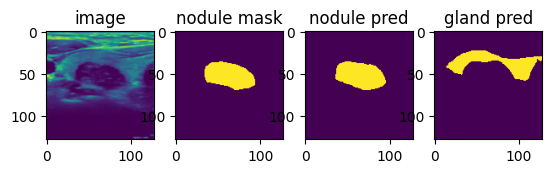

  3%|▎         | 5/191 [00:00<00:17, 10.49it/s]

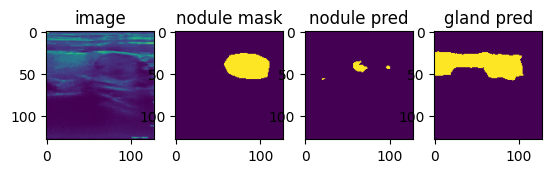

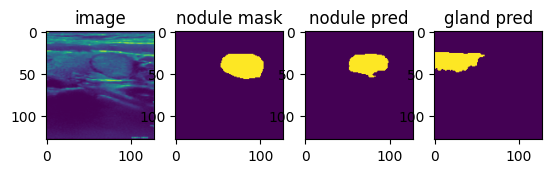

  4%|▎         | 7/191 [00:02<01:14,  2.46it/s]

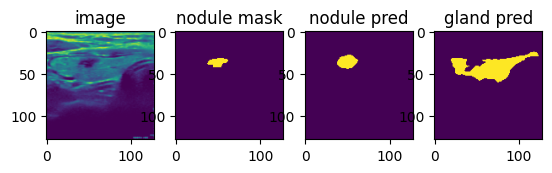

  5%|▍         | 9/191 [00:02<00:57,  3.18it/s]

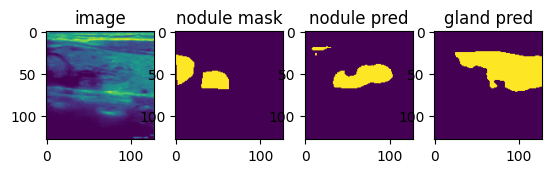

  7%|▋         | 13/191 [00:04<00:58,  3.03it/s]

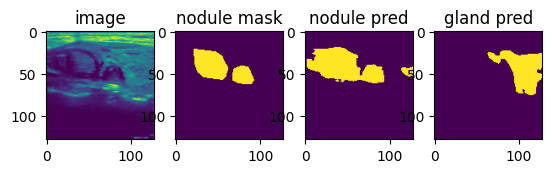

  8%|▊         | 16/191 [00:04<00:58,  2.98it/s]

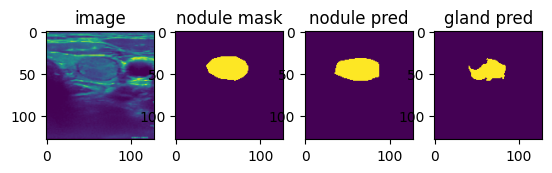

  9%|▉         | 17/191 [00:05<00:56,  3.07it/s]

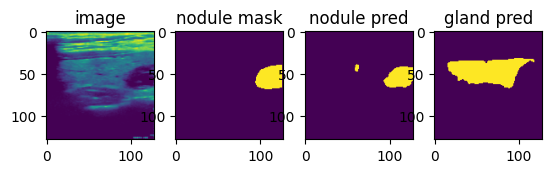

  9%|▉         | 18/191 [00:05<01:10,  2.45it/s]

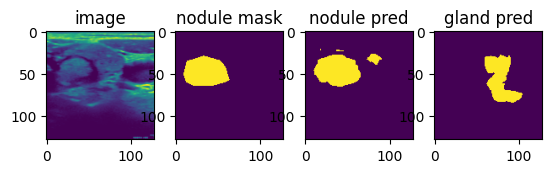

 10%|█         | 20/191 [00:06<01:09,  2.46it/s]

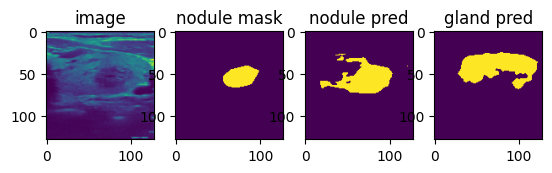

 11%|█         | 21/191 [00:07<01:05,  2.61it/s]

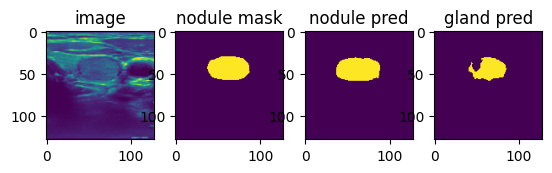

 13%|█▎        | 24/191 [00:07<00:39,  4.27it/s]

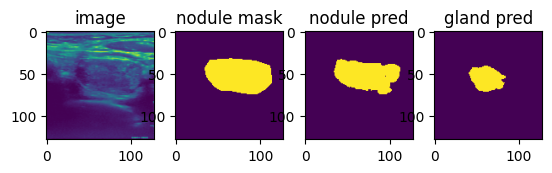

 13%|█▎        | 25/191 [00:07<00:41,  4.01it/s]

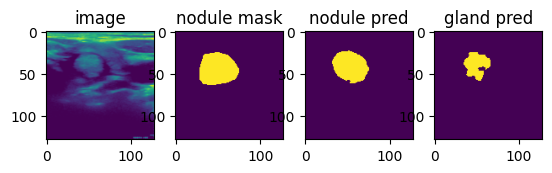

 14%|█▎        | 26/191 [00:08<00:55,  2.95it/s]

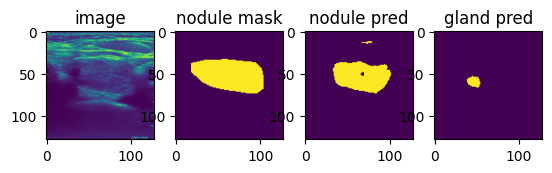

 15%|█▌        | 29/191 [00:09<00:47,  3.39it/s]

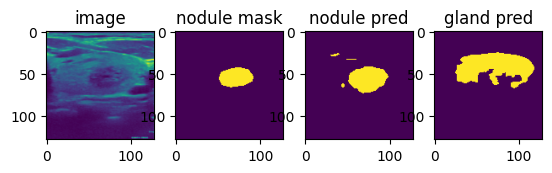

 16%|█▌        | 30/191 [00:10<01:13,  2.18it/s]

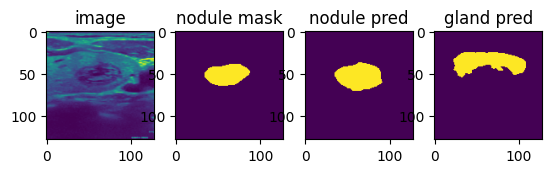

 17%|█▋        | 33/191 [00:11<01:14,  2.12it/s]

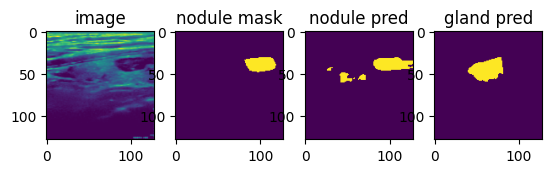

 19%|█▉        | 36/191 [00:12<00:44,  3.51it/s]

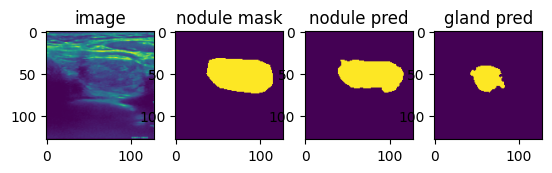

 21%|██        | 40/191 [00:12<00:26,  5.77it/s]

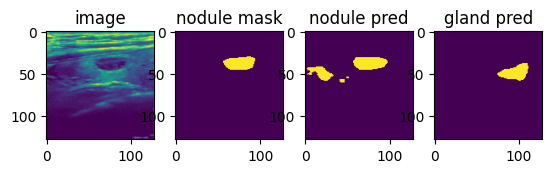

 21%|██▏       | 41/191 [00:13<00:39,  3.76it/s]

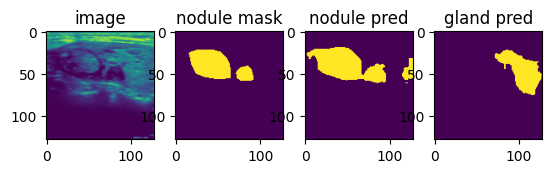

 22%|██▏       | 42/191 [00:13<00:40,  3.70it/s]

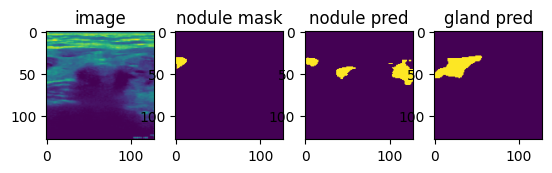

 23%|██▎       | 43/191 [00:13<00:39,  3.71it/s]

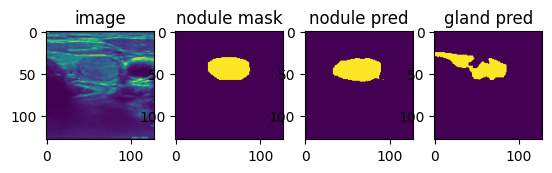

 23%|██▎       | 44/191 [00:13<00:39,  3.70it/s]

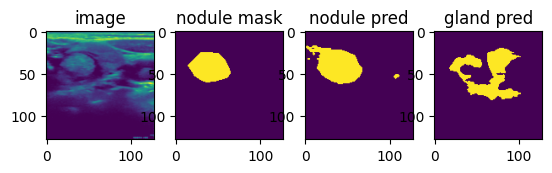

 24%|██▎       | 45/191 [00:14<01:03,  2.29it/s]

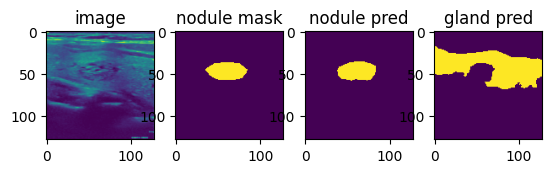

 24%|██▍       | 46/191 [00:15<00:57,  2.54it/s]

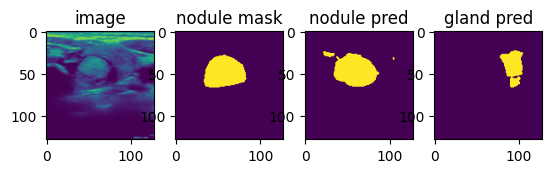

 26%|██▌       | 49/191 [00:15<00:35,  4.04it/s]

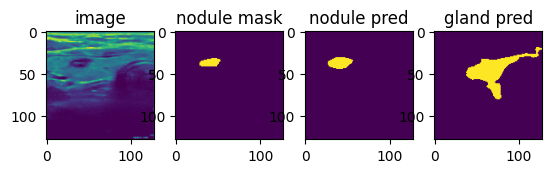

 26%|██▌       | 50/191 [00:16<00:52,  2.68it/s]

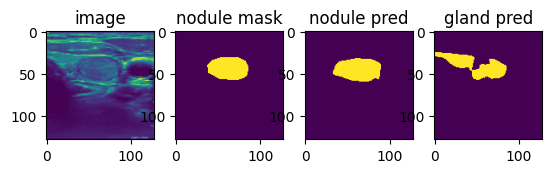

 27%|██▋       | 51/191 [00:16<01:00,  2.30it/s]

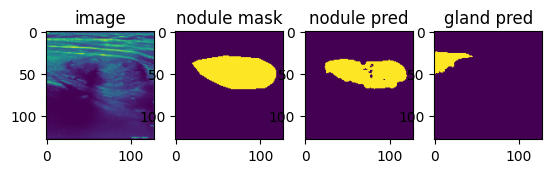

 28%|██▊       | 53/191 [00:17<00:45,  3.01it/s]

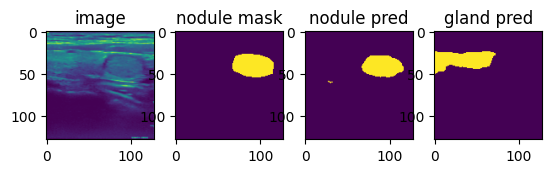

 28%|██▊       | 54/191 [00:17<00:43,  3.15it/s]

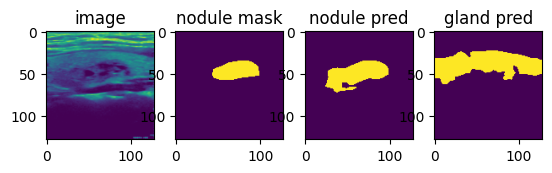

 29%|██▉       | 56/191 [00:18<00:51,  2.60it/s]

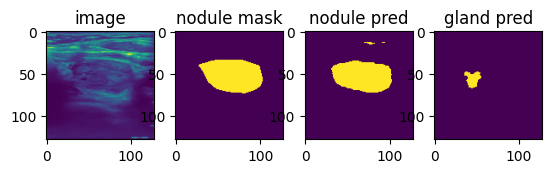

 30%|██▉       | 57/191 [00:19<00:59,  2.26it/s]

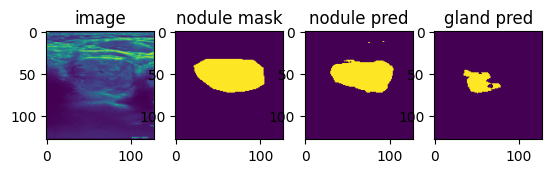

 32%|███▏      | 61/191 [00:20<00:43,  3.01it/s]

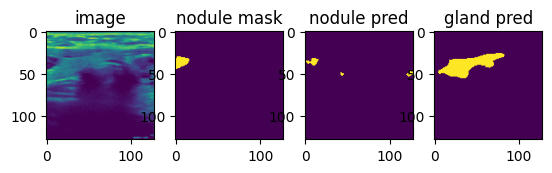

 32%|███▏      | 62/191 [00:21<00:41,  3.11it/s]

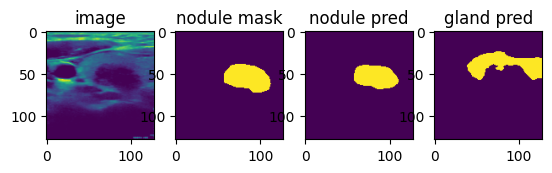

 34%|███▎      | 64/191 [00:21<00:31,  4.04it/s]

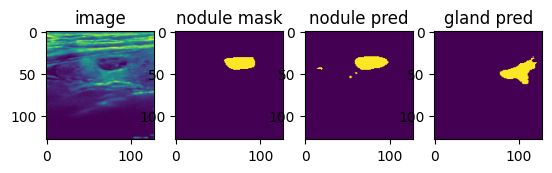

 34%|███▍      | 65/191 [00:21<00:34,  3.67it/s]

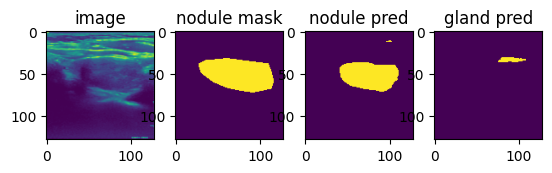

 36%|███▌      | 69/191 [00:23<00:55,  2.19it/s]

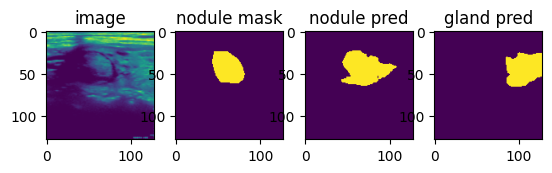

 38%|███▊      | 72/191 [00:25<00:53,  2.21it/s]

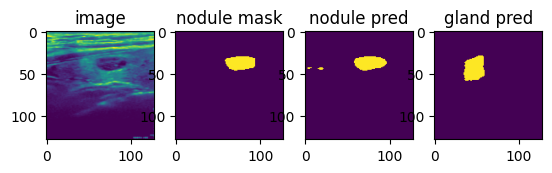

 40%|███▉      | 76/191 [00:25<00:30,  3.77it/s]

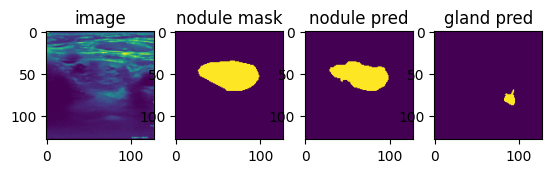

 41%|████      | 78/191 [00:26<00:31,  3.53it/s]

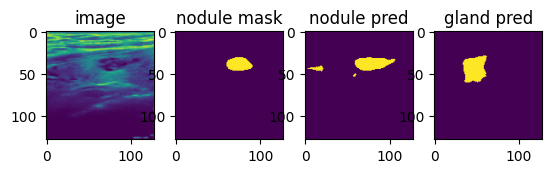

 42%|████▏     | 80/191 [00:28<00:59,  1.88it/s]

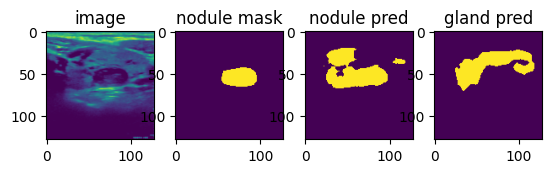

 43%|████▎     | 83/191 [00:28<00:33,  3.26it/s]

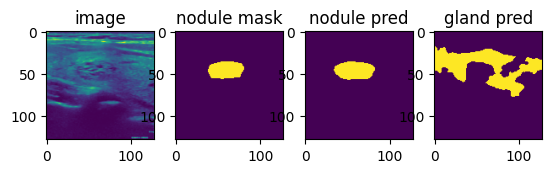

 45%|████▍     | 85/191 [00:29<00:28,  3.74it/s]

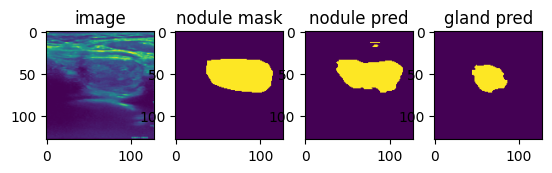

 46%|████▌     | 87/191 [00:29<00:24,  4.33it/s]

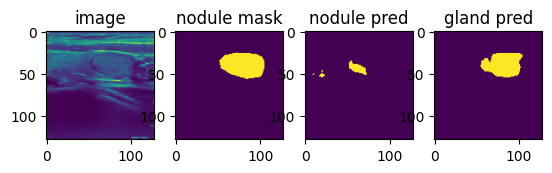

 46%|████▌     | 88/191 [00:30<00:36,  2.80it/s]

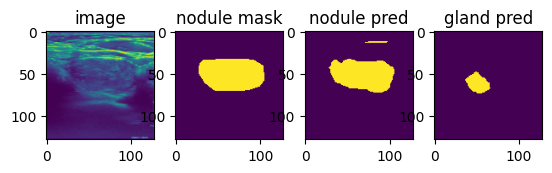

 47%|████▋     | 89/191 [00:30<00:45,  2.24it/s]

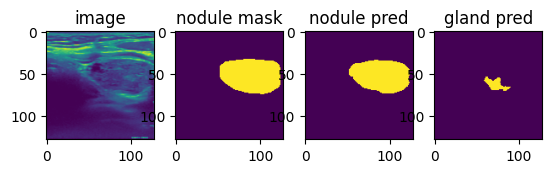

 49%|████▉     | 94/191 [00:32<00:34,  2.85it/s]

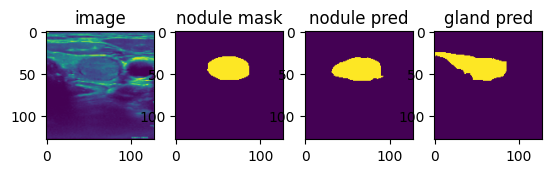

 50%|████▉     | 95/191 [00:32<00:32,  2.98it/s]

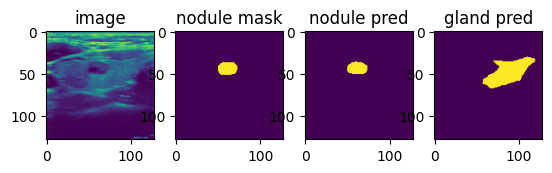

 50%|█████     | 96/191 [00:33<00:51,  1.83it/s]

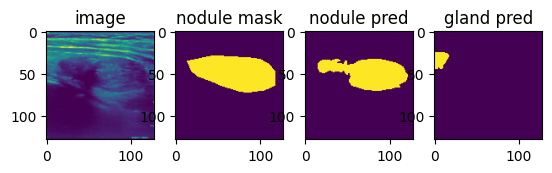

 51%|█████     | 97/191 [00:35<01:05,  1.44it/s]

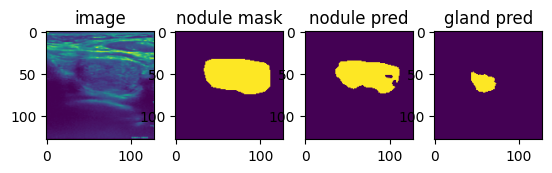

 51%|█████▏    | 98/191 [00:35<01:07,  1.38it/s]

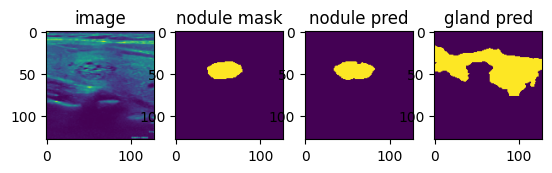

 52%|█████▏    | 100/191 [00:36<00:56,  1.61it/s]

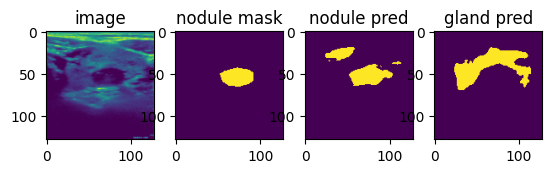

 55%|█████▍    | 105/191 [00:39<00:32,  2.68it/s]


KeyboardInterrupt: 

In [27]:
test_dataset = Ge_Benq_Dataset("../ge_benq_data/ge_benq_test.csv", transform = test_augmentation, image_size = image_size, training = False, allow_zero_mask = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)
model.to("cpu")
for image, mask, from_dataset in tqdm(test_dataloader):
    if image != None:
        outputs = model(image)
        if from_dataset[0] == 1:
            nodule_output = outputs[:, 0:1, :, :]
            gland_output = outputs[:, 1:2, :, :]
            
            ge_output = nodule_output[from_dataset==1]
            ge_output = torch.sigmoid(ge_output)
            ge_output = ge_output > 0.5
            ge_mask = mask[from_dataset==1]

            gland_output = postprocess_logits_with_fill(gland_output)
            # gland_output = gland_output > 0.5
            
            plt.subplot(1,4,1)
            plt.imshow(image[0][0])
            plt.title("image")
            plt.subplot(1,4,2)
            plt.imshow(ge_mask[0][0])
            plt.title("nodule mask")
            plt.subplot(1,4,3)
            plt.imshow(ge_output[0][0].detach().numpy())
            plt.title("nodule pred")
            plt.subplot(1,4,4)
            plt.imshow(gland_output[0][0].detach().numpy())
            plt.title("gland pred")
            plt.show()

# visualize benq non-zero mask

  1%|          | 2/191 [00:02<04:46,  1.52s/it]

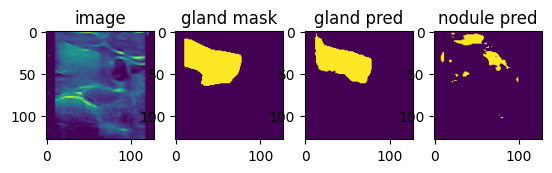

  2%|▏         | 3/191 [00:03<03:00,  1.04it/s]

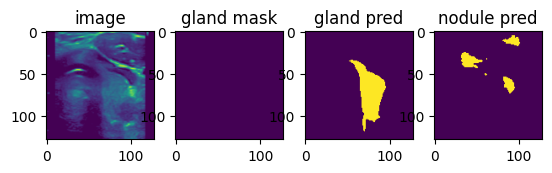

  2%|▏         | 4/191 [00:03<02:09,  1.45it/s]

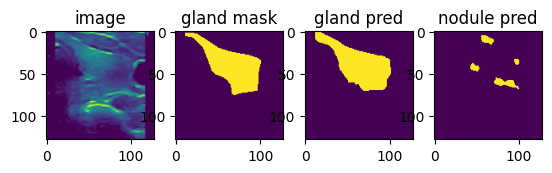

  5%|▍         | 9/191 [00:03<00:37,  4.80it/s]

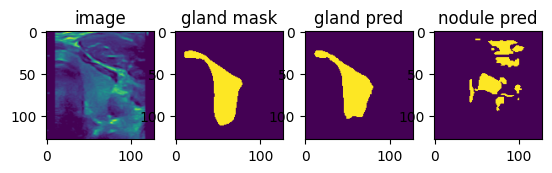

  6%|▌         | 11/191 [00:04<00:54,  3.29it/s]

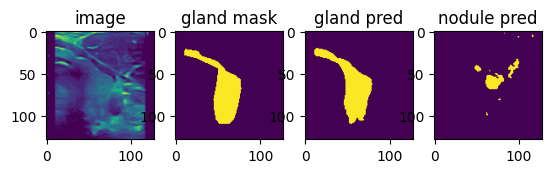

  6%|▋         | 12/191 [00:05<00:53,  3.36it/s]

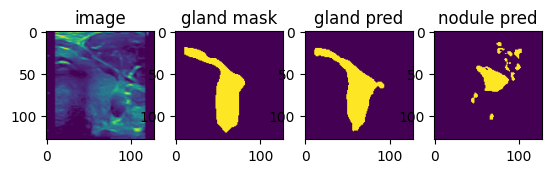

  7%|▋         | 13/191 [00:05<00:52,  3.41it/s]

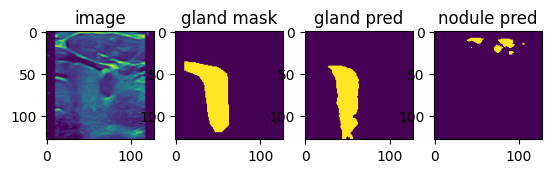

  7%|▋         | 14/191 [00:05<00:51,  3.47it/s]

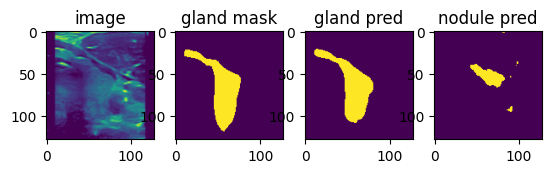

  9%|▉         | 18/191 [00:06<00:31,  5.54it/s]

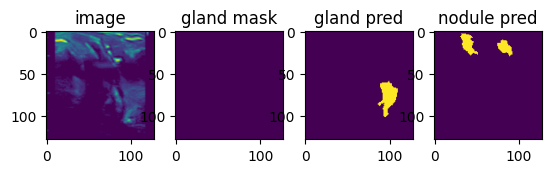

 12%|█▏        | 22/191 [00:07<00:45,  3.72it/s]

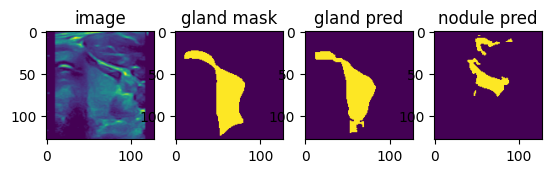

 12%|█▏        | 23/191 [00:08<01:04,  2.62it/s]

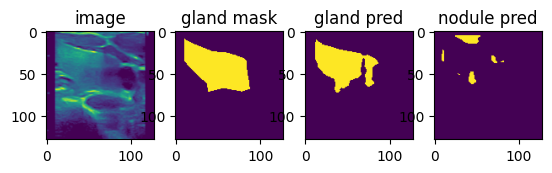

 15%|█▍        | 28/191 [00:08<00:29,  5.53it/s]

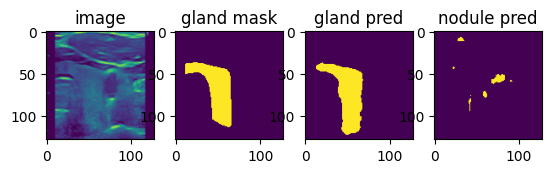

 16%|█▌        | 31/191 [00:09<00:24,  6.43it/s]

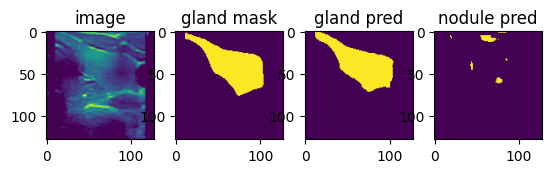

 18%|█▊        | 34/191 [00:10<00:49,  3.14it/s]

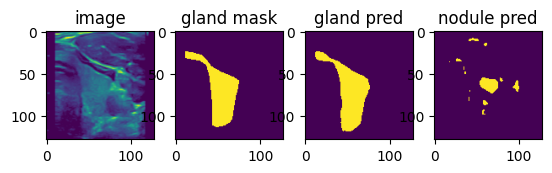

 18%|█▊        | 35/191 [00:10<00:49,  3.18it/s]

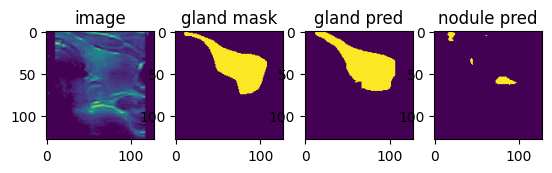

 19%|█▉        | 36/191 [00:11<00:46,  3.31it/s]

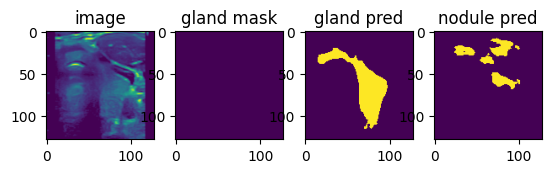

 19%|█▉        | 37/191 [00:11<00:45,  3.42it/s]

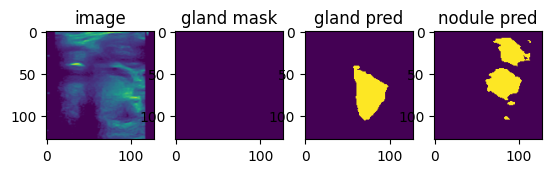

 20%|█▉        | 38/191 [00:11<00:43,  3.48it/s]

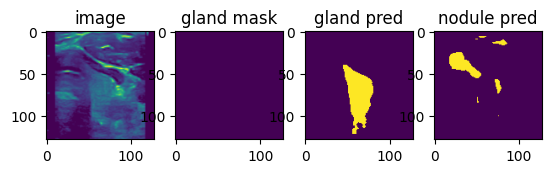

 24%|██▍       | 46/191 [00:14<00:44,  3.25it/s]

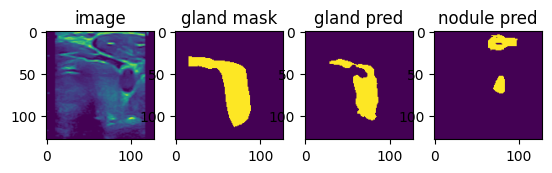

 27%|██▋       | 51/191 [00:16<00:51,  2.71it/s]

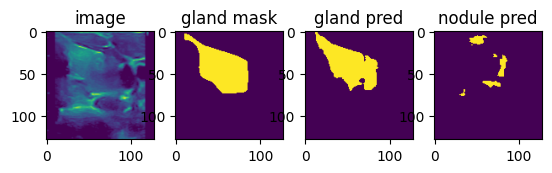

 29%|██▉       | 55/191 [00:18<00:52,  2.59it/s]

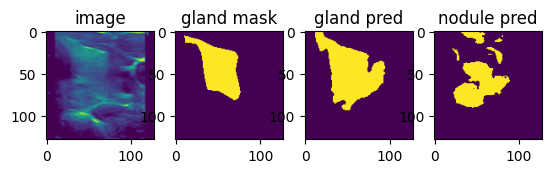

 30%|███       | 58/191 [00:18<00:32,  4.11it/s]

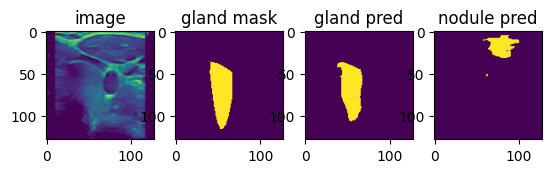

 31%|███       | 59/191 [00:18<00:33,  3.95it/s]

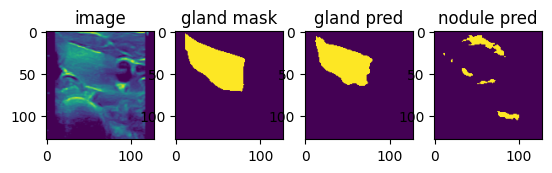

 31%|███▏      | 60/191 [00:19<00:33,  3.87it/s]

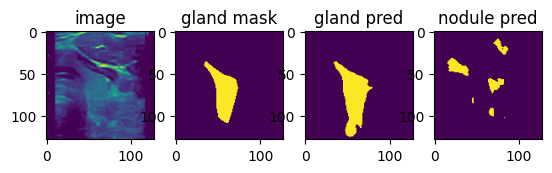

 32%|███▏      | 61/191 [00:19<00:46,  2.77it/s]

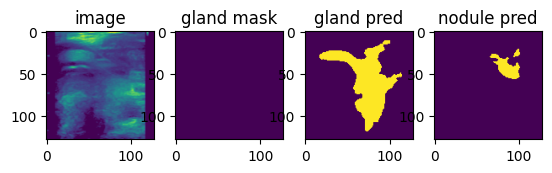

 34%|███▎      | 64/191 [00:21<00:56,  2.24it/s]

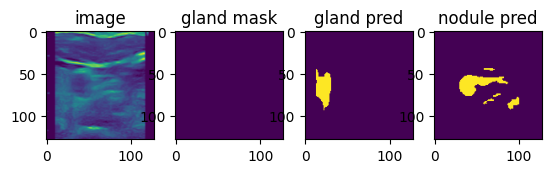

 36%|███▌      | 68/191 [00:21<00:29,  4.11it/s]

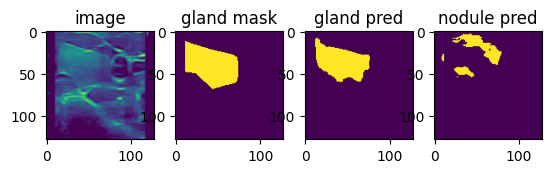

 37%|███▋      | 70/191 [00:23<00:59,  2.02it/s]

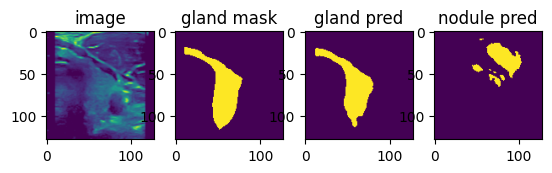

 38%|███▊      | 72/191 [00:24<01:01,  1.95it/s]

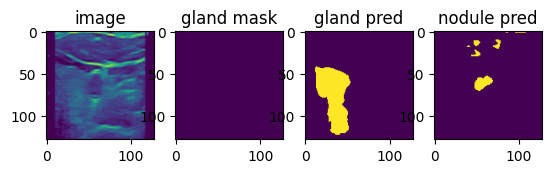

 38%|███▊      | 73/191 [00:24<00:54,  2.16it/s]

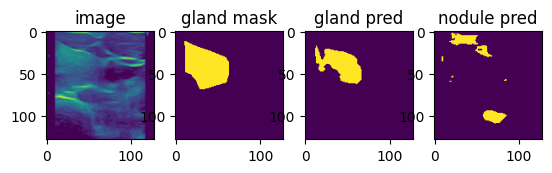

 39%|███▊      | 74/191 [00:24<00:48,  2.39it/s]

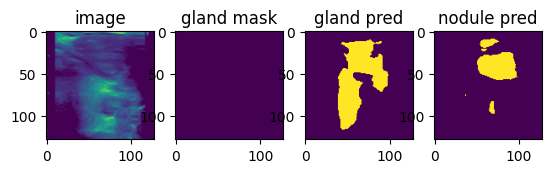

 40%|████      | 77/191 [00:26<00:48,  2.37it/s]

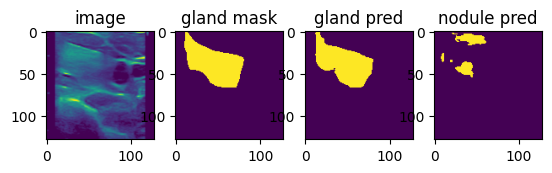

 41%|████▏     | 79/191 [00:27<01:00,  1.84it/s]

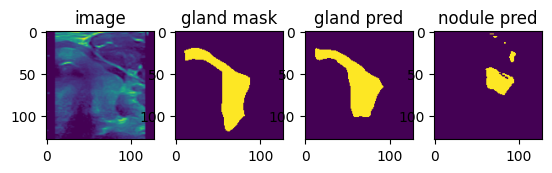

 42%|████▏     | 81/191 [00:28<00:47,  2.33it/s]

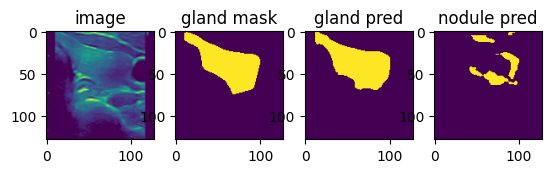

 43%|████▎     | 82/191 [00:28<00:42,  2.56it/s]

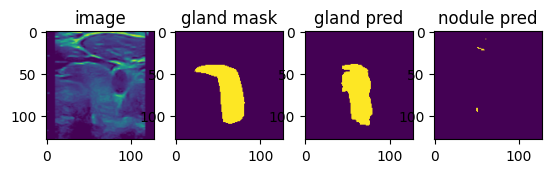

 44%|████▍     | 84/191 [00:29<00:54,  1.95it/s]

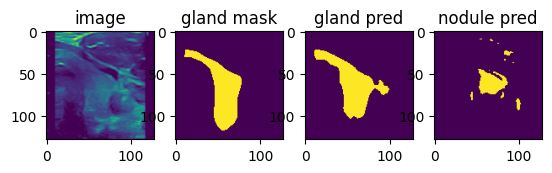

 45%|████▍     | 85/191 [00:29<00:47,  2.24it/s]

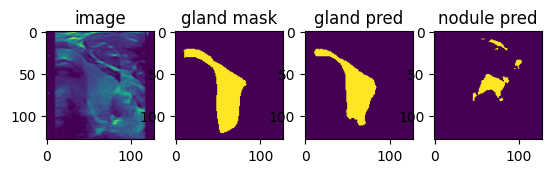

 47%|████▋     | 90/191 [00:31<00:32,  3.14it/s]

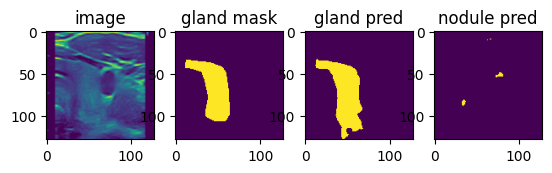

 48%|████▊     | 91/191 [00:31<00:30,  3.24it/s]

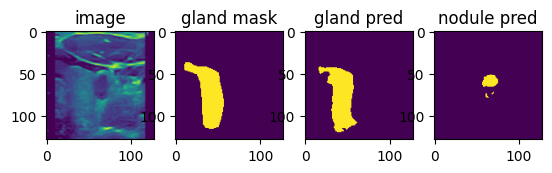

 48%|████▊     | 92/191 [00:31<00:29,  3.36it/s]

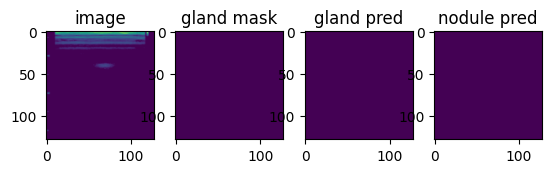

 49%|████▊     | 93/191 [00:32<00:28,  3.45it/s]

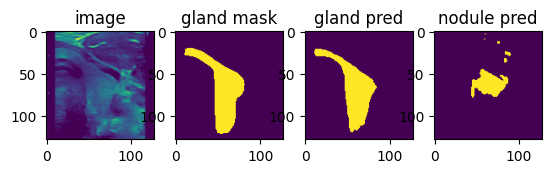

 51%|█████▏    | 98/191 [00:33<00:23,  3.97it/s]

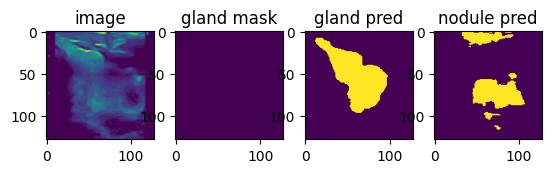

 53%|█████▎    | 101/191 [00:34<00:16,  5.31it/s]

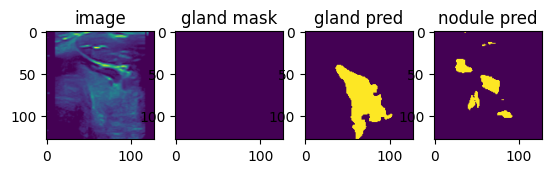

 53%|█████▎    | 102/191 [00:34<00:18,  4.71it/s]

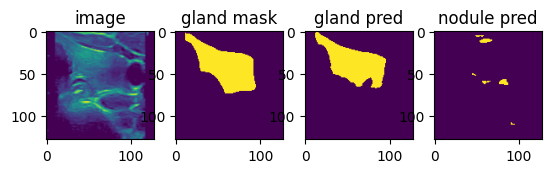

 54%|█████▍    | 103/191 [00:34<00:22,  3.86it/s]

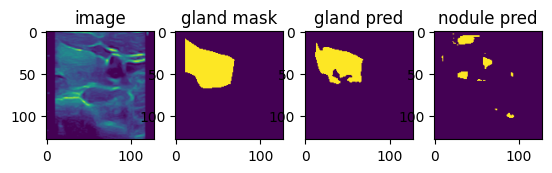

 54%|█████▍    | 104/191 [00:35<00:22,  3.81it/s]

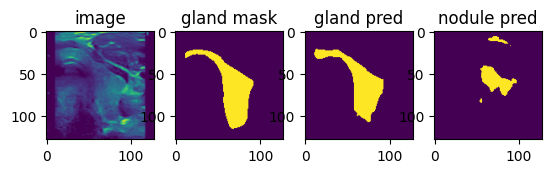

 56%|█████▌    | 107/191 [00:37<01:02,  1.33it/s]

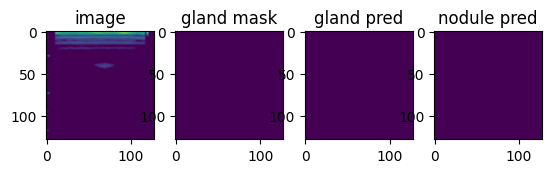

 57%|█████▋    | 109/191 [00:38<00:48,  1.71it/s]

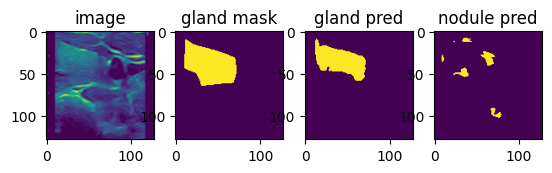

 58%|█████▊    | 111/191 [00:39<00:40,  1.98it/s]

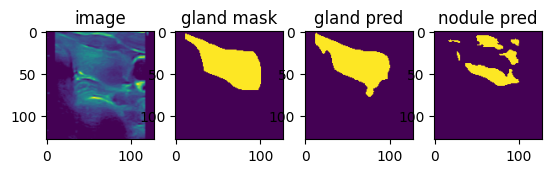

 61%|██████▏   | 117/191 [00:40<00:15,  4.87it/s]

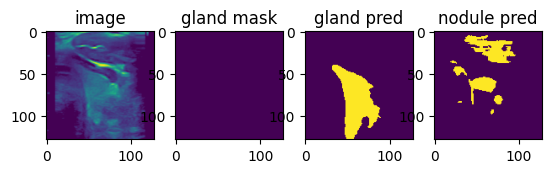

 62%|██████▏   | 119/191 [00:41<00:22,  3.15it/s]

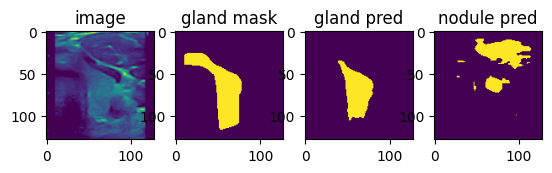

 63%|██████▎   | 121/191 [00:42<00:37,  1.86it/s]

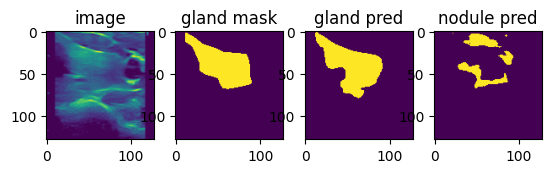

 64%|██████▍   | 122/191 [00:43<00:43,  1.59it/s]

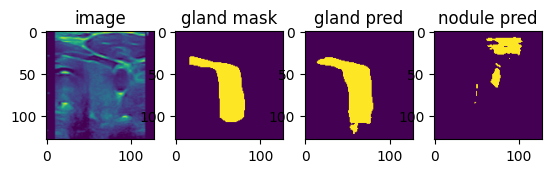

 64%|██████▍   | 123/191 [00:44<00:52,  1.29it/s]

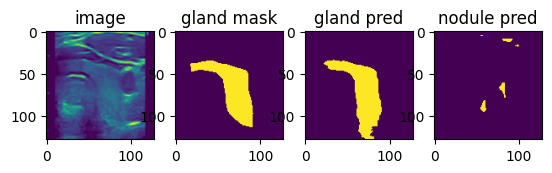

 65%|██████▌   | 125/191 [00:46<00:47,  1.38it/s]

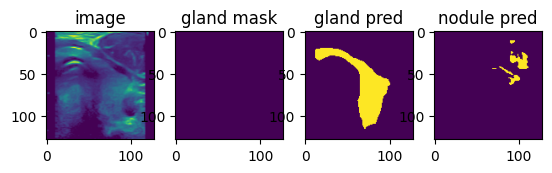

 66%|██████▌   | 126/191 [00:46<00:38,  1.68it/s]

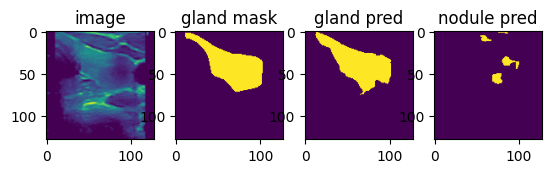

 67%|██████▋   | 128/191 [00:46<00:25,  2.49it/s]

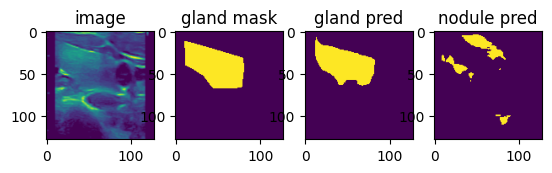

 68%|██████▊   | 130/191 [00:47<00:19,  3.13it/s]

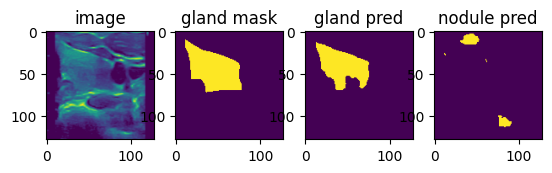

 69%|██████▊   | 131/191 [00:49<00:41,  1.44it/s]

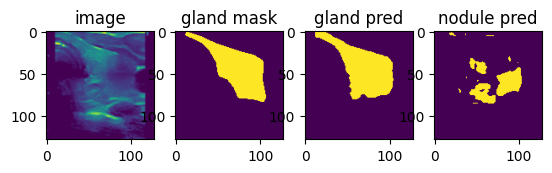

 72%|███████▏  | 138/191 [00:50<00:19,  2.70it/s]

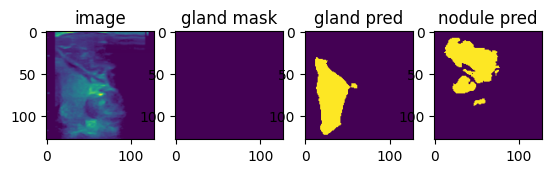

 73%|███████▎  | 139/191 [00:50<00:18,  2.85it/s]

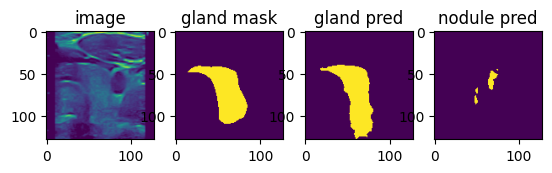

 74%|███████▍  | 142/191 [00:51<00:14,  3.32it/s]

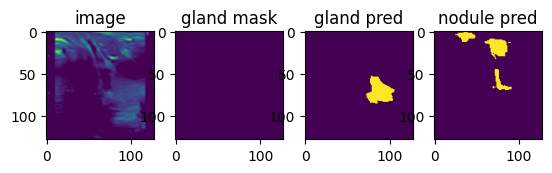

 77%|███████▋  | 148/191 [00:53<00:10,  4.14it/s]

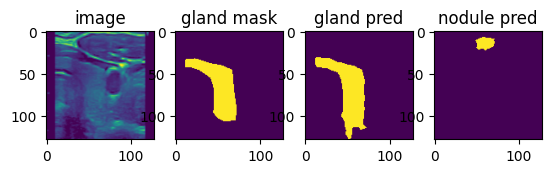

 81%|████████  | 154/191 [00:58<00:39,  1.08s/it]

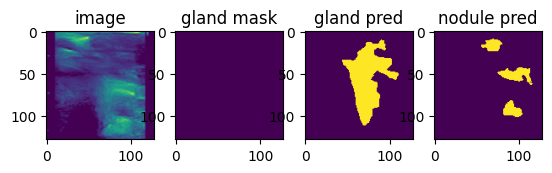

 81%|████████  | 155/191 [00:58<00:31,  1.15it/s]

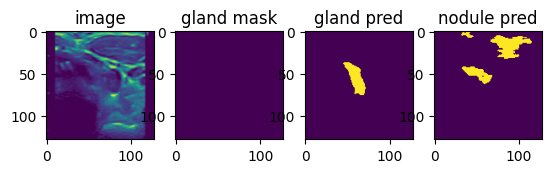

 82%|████████▏ | 157/191 [00:59<00:22,  1.54it/s]

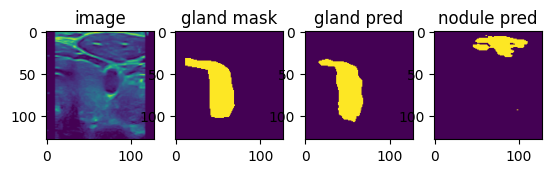

 83%|████████▎ | 158/191 [01:00<00:18,  1.83it/s]

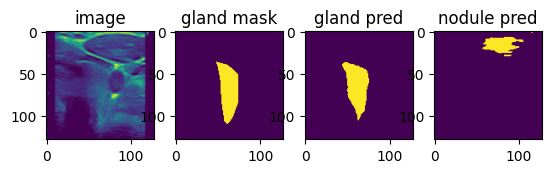

 83%|████████▎ | 159/191 [01:00<00:14,  2.14it/s]

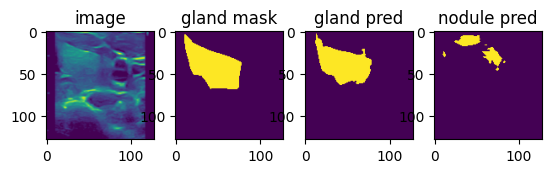

 85%|████████▌ | 163/191 [01:02<00:15,  1.79it/s]

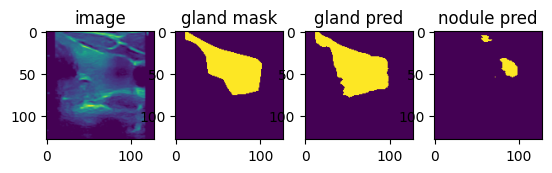

 86%|████████▋ | 165/191 [01:03<00:15,  1.72it/s]

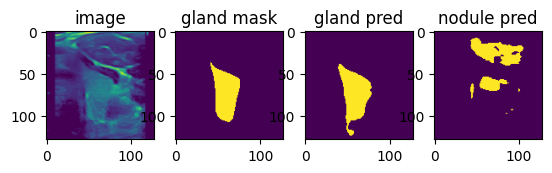

 87%|████████▋ | 167/191 [01:04<00:12,  1.86it/s]

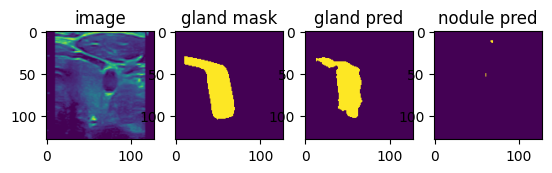

 88%|████████▊ | 169/191 [01:05<00:08,  2.45it/s]

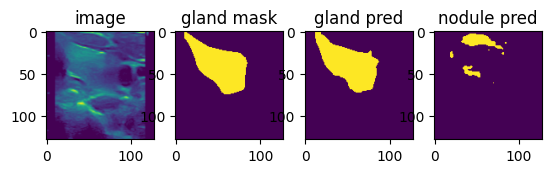

 89%|████████▉ | 170/191 [01:05<00:08,  2.62it/s]

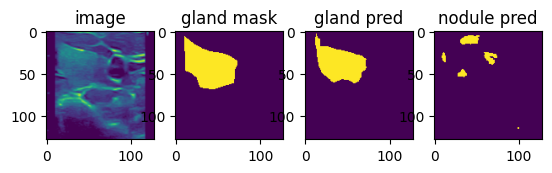

 93%|█████████▎| 177/191 [01:10<00:10,  1.36it/s]

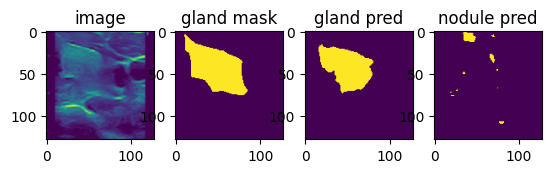

 93%|█████████▎| 178/191 [01:10<00:07,  1.65it/s]

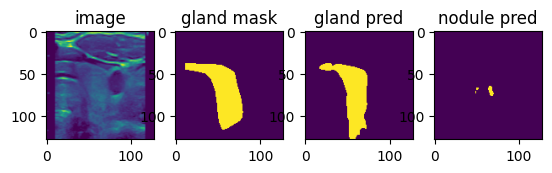

 95%|█████████▍| 181/191 [01:11<00:03,  2.76it/s]

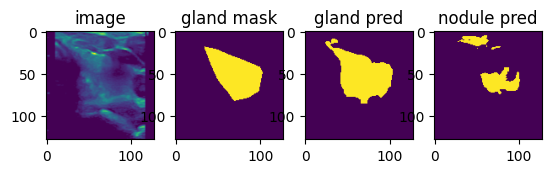

 95%|█████████▌| 182/191 [01:12<00:03,  2.89it/s]

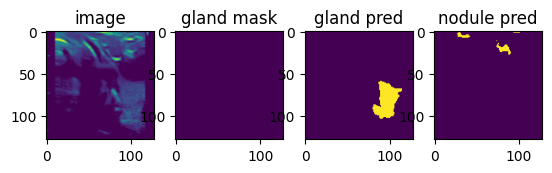

 97%|█████████▋| 185/191 [01:12<00:01,  3.56it/s]

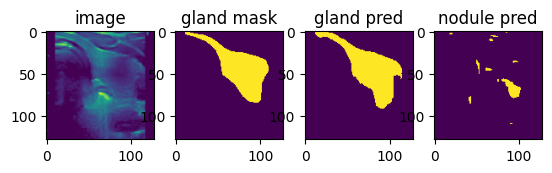

 99%|█████████▉| 190/191 [01:15<00:00,  2.53it/s]

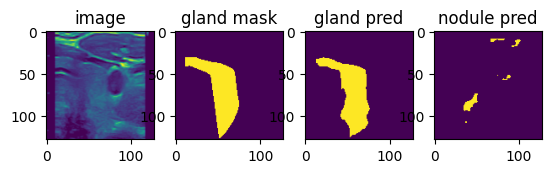

100%|██████████| 191/191 [01:15<00:00,  2.53it/s]


In [30]:
test_dataset = Ge_Benq_Dataset("../ge_benq_data/ge_benq_test.csv", transform = test_augmentation, image_size = image_size, training = False, allow_zero_mask = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)
model.to("cpu")
for image, mask, from_dataset in tqdm(test_dataloader):
    if image!=None:
        outputs = model(image)
        if from_dataset[0] == 2:
            nodule_output = outputs[:, 0:1, :, :]
            gland_output = outputs[:, 1:2, :, :]
            benq_output = gland_output[from_dataset==2]

            benq_output = postprocess_logits_with_fill(benq_output)
            benq_mask = mask[from_dataset==2]
            nodule_output = torch.sigmoid(nodule_output)
            nodule_output = nodule_output > 0.5
            plt.subplot(1,4,1)
            plt.imshow(image[0][0])
            plt.title("image")
            plt.subplot(1,4,2)
            plt.imshow(benq_mask[0][0])
            plt.title("gland mask")
            plt.subplot(1,4,3)
            plt.imshow(benq_output[0][0].detach().numpy())
            plt.title("gland pred")
            plt.subplot(1,4,4)
            plt.imshow(nodule_output[0][0].detach().numpy())
            plt.title("nodule pred")
            plt.show()

# visualize ge zero mask

  0%|          | 0/191 [00:00<?, ?it/s]

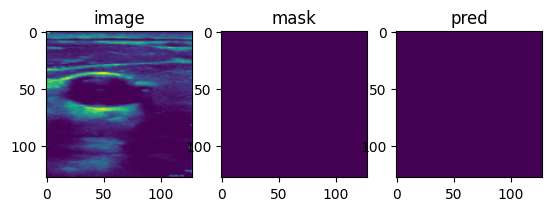

  2%|▏         | 4/191 [00:02<02:04,  1.50it/s]

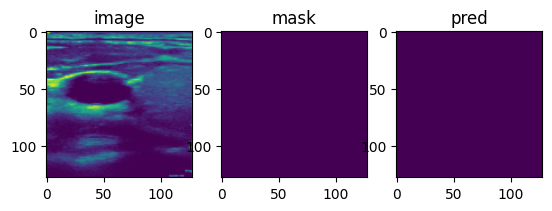

 10%|▉         | 19/191 [00:02<00:15, 10.78it/s]

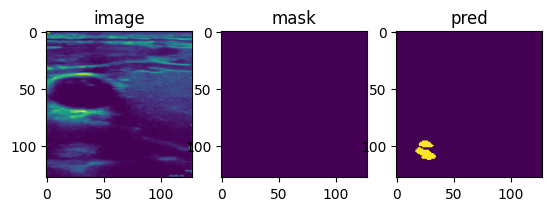

 15%|█▍        | 28/191 [00:03<00:10, 14.91it/s]

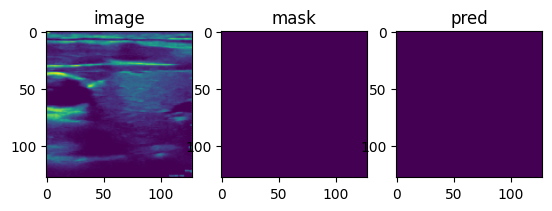

 21%|██        | 40/191 [00:03<00:09, 15.26it/s]

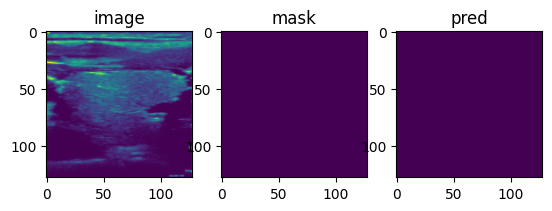

 34%|███▎      | 64/191 [00:04<00:05, 25.20it/s]

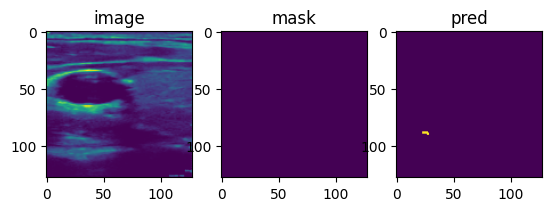

 36%|███▌      | 69/191 [00:05<00:05, 21.45it/s]

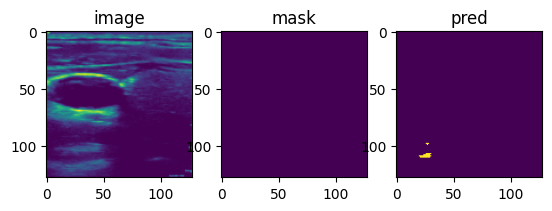

 59%|█████▊    | 112/191 [00:07<00:03, 21.30it/s]

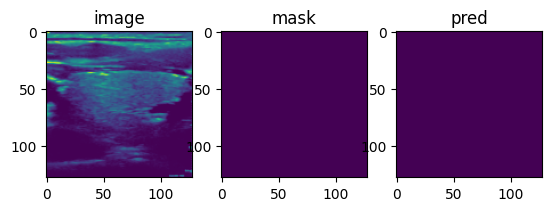

 72%|███████▏  | 138/191 [00:09<00:03, 17.39it/s]

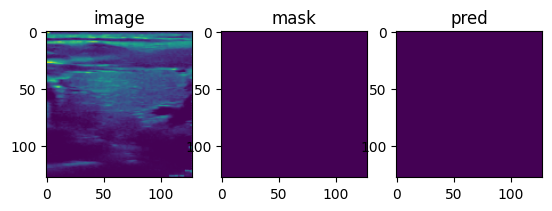

 75%|███████▍  | 143/191 [00:10<00:04, 10.78it/s]

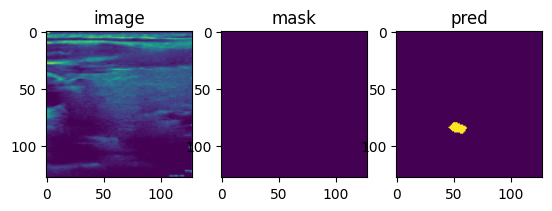

 95%|█████████▌| 182/191 [00:11<00:00, 34.37it/s]

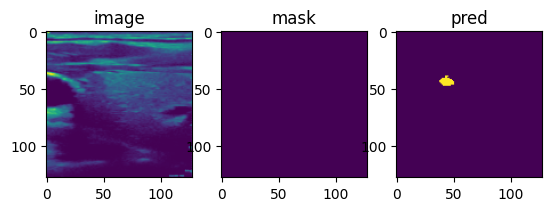

100%|██████████| 191/191 [00:12<00:00, 15.83it/s]


In [20]:
test_dataset = Ge_Benq_Dataset("../ge_benq_data/ge_benq_test.csv", transform = test_augmentation, image_size = image_size, training = False, allow_zero_mask = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)
model.to("cpu")
for image, mask, from_dataset in tqdm(test_dataloader):
    if torch.sum(mask) == 0:
        outputs = model(image)
        if from_dataset[0] == 1:
            nodule_output = outputs[:, 0:1, :, :]
            ge_output = nodule_output[from_dataset==1]
            ge_output = torch.sigmoid(ge_output)
            ge_output = ge_output > 0.5
            ge_mask = mask[from_dataset==1]

            plt.subplot(1,3,1)
            plt.imshow(image[0][0])
            plt.title("image")
            plt.subplot(1,3,2)
            plt.imshow(ge_mask[0][0])
            plt.title("mask")
            plt.subplot(1,3,3)
            plt.imshow(ge_output[0][0].detach().numpy())
            plt.title("pred")
            plt.show()

# visualize benq zero mask

  2%|▏         | 3/191 [00:00<00:06, 29.55it/s]

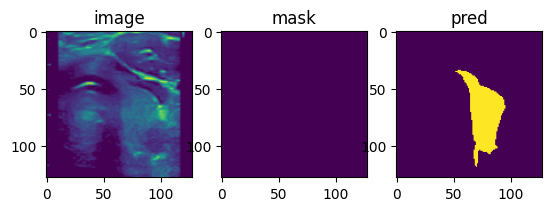

  5%|▌         | 10/191 [00:00<00:08, 22.38it/s]

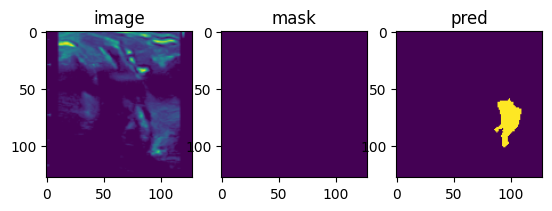

 17%|█▋        | 32/191 [00:02<00:11, 14.00it/s]

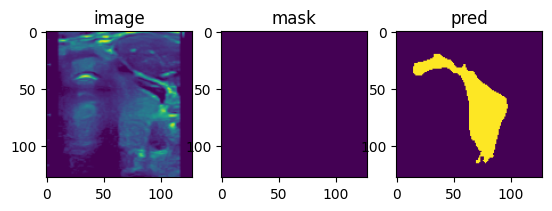

 19%|█▉        | 37/191 [00:02<00:10, 15.06it/s]

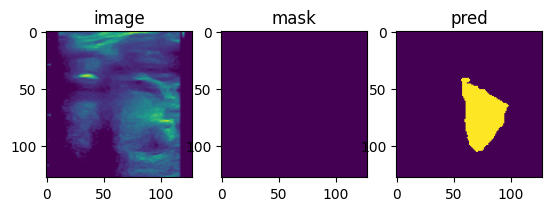

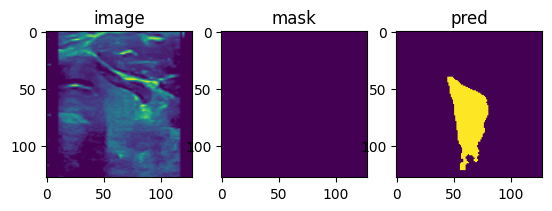

 31%|███       | 59/191 [00:04<00:08, 15.29it/s]

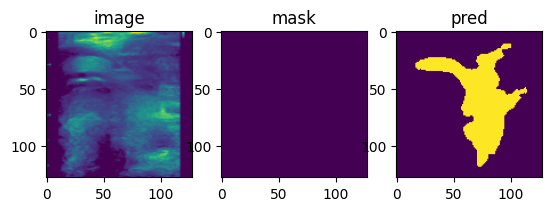

 34%|███▎      | 64/191 [00:04<00:08, 14.97it/s]

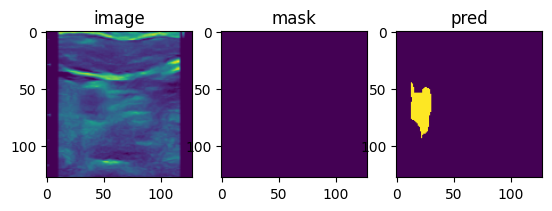

 37%|███▋      | 71/191 [00:06<00:14,  8.20it/s]

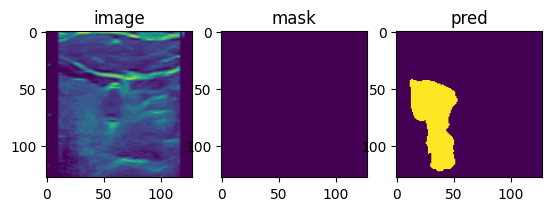

 38%|███▊      | 73/191 [00:06<00:16,  7.22it/s]

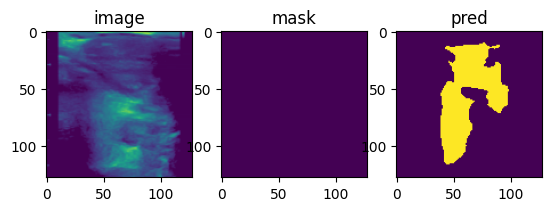

 45%|████▌     | 86/191 [00:07<00:07, 13.17it/s]

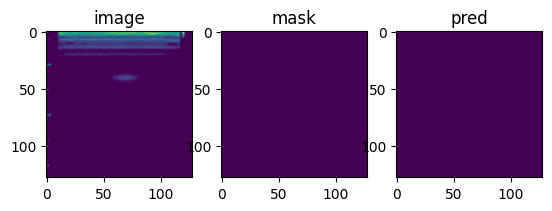

 49%|████▊     | 93/191 [00:07<00:06, 15.76it/s]

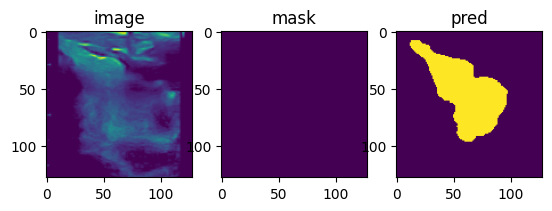

 52%|█████▏    | 99/191 [00:08<00:06, 14.66it/s]

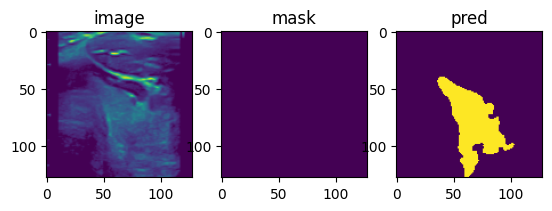

 53%|█████▎    | 102/191 [00:08<00:06, 14.03it/s]

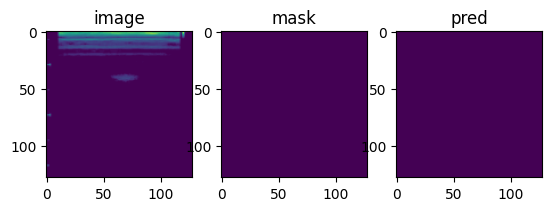

 60%|█████▉    | 114/191 [00:09<00:04, 15.74it/s]

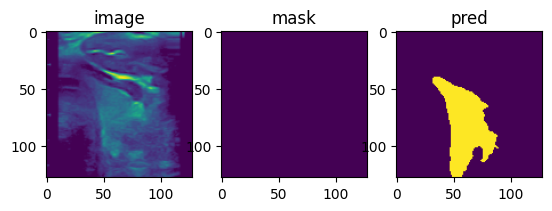

 62%|██████▏   | 118/191 [00:09<00:05, 13.21it/s]

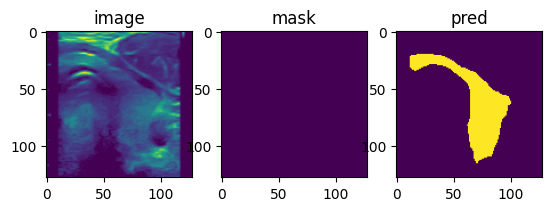

 72%|███████▏  | 137/191 [00:10<00:02, 19.79it/s]

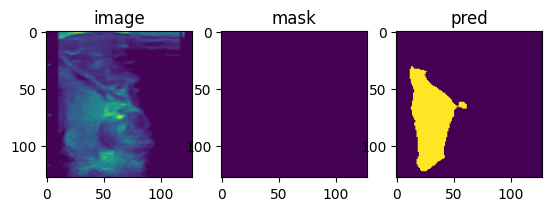

 74%|███████▍  | 142/191 [00:11<00:03, 12.69it/s]

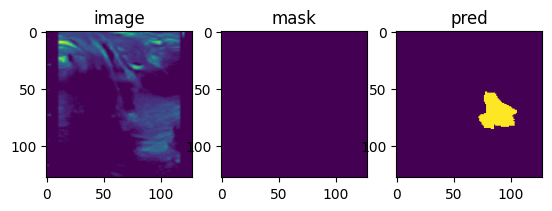

 76%|███████▋  | 146/191 [00:12<00:04, 10.85it/s]

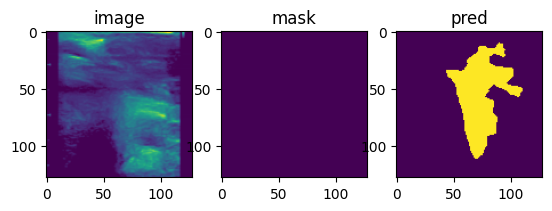

 81%|████████  | 155/191 [00:13<00:03, 10.11it/s]

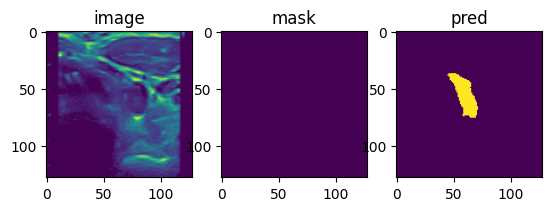

 95%|█████████▍| 181/191 [00:13<00:00, 24.86it/s]

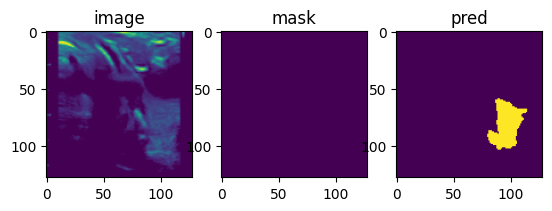

100%|██████████| 191/191 [00:14<00:00, 13.56it/s]


In [31]:
test_dataset = Ge_Benq_Dataset("../ge_benq_data/ge_benq_test.csv", transform = test_augmentation, image_size = image_size, training = False, allow_zero_mask = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)
model.to("cpu")
for image, mask, from_dataset in tqdm(test_dataloader):
    if torch.sum(mask) == 0:
        outputs = model(image)
        if from_dataset[0] == 2:
            gland_output = outputs[:, 1:2, :, :]
            benq_output = gland_output[from_dataset==2]
            benq_output = postprocess_logits_with_fill(benq_output)
            # benq_output = torch.sigmoid(benq_output)
            # benq_output = benq_output > 0.5
            benq_mask = mask[from_dataset==2]

            plt.subplot(1,3,1)
            plt.imshow(image[0][0])
            plt.title("image")
            plt.subplot(1,3,2)
            plt.imshow(benq_mask[0][0])
            plt.title("mask")
            plt.subplot(1,3,3)
            plt.imshow(benq_output[0][0].detach().numpy())
            plt.title("pred")
            plt.show()